In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

import pandas as pd
import os
import sys

sys.path.append(os.path.abspath(".."))
from utils import plot_feature_importances, transform_pred_to_labels, plot_roc_curve, plot_gammaness_distribution, resolution_per_bin, plot_resolution_two_curves

In [2]:
# load CSV with results
results_cl_64_df = pd.read_csv('rf_ae_hexa/rf_results_clf.csv')
results_rg_64_df = pd.read_csv('rf_ae_hexa/rf_results_rg.csv')

results_cl_32_df = pd.read_csv('rf_ae_hexa_32/rf_results_clf.csv')
results_rg_32_df = pd.read_csv('rf_ae_hexa_32/rf_results_rg.csv')

results_cl_128_df = pd.read_csv('rf_ae_hexa_128/rf_results_clf.csv')
results_rg_128_df = pd.read_csv('rf_ae_hexa_128/rf_results_rg.csv')

In [3]:
def plot_roc_curve_4(y_true, y_pred1, y_pred2, y_pred3, y_pred4, label1, label2, label3, label4):

    fpr1, tpr1, _ = roc_curve(y_true, y_pred1)
    auc1 = auc(fpr1, tpr1)

    fpr2, tpr2, _ = roc_curve(y_true, y_pred2)
    auc2 = auc(fpr2, tpr2)

    fpr3, tpr3, _ = roc_curve(y_true, y_pred3)
    auc3 = auc(fpr3, tpr3)

    fpr4, tpr4, _ = roc_curve(y_true, y_pred4)
    auc4 = auc(fpr4, tpr4)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, label=f"{label1} (AUC = {auc1:.3f})", color="red")
    plt.plot(fpr2, tpr2, label=f"{label2} (AUC = {auc2:.3f})", color="orange")
    plt.plot(fpr3, tpr3, label=f"{label3} (AUC = {auc3:.3f})", color="green")
    plt.plot(fpr4, tpr4, label=f"{label4} (AUC = {auc4:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random guess")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.show()

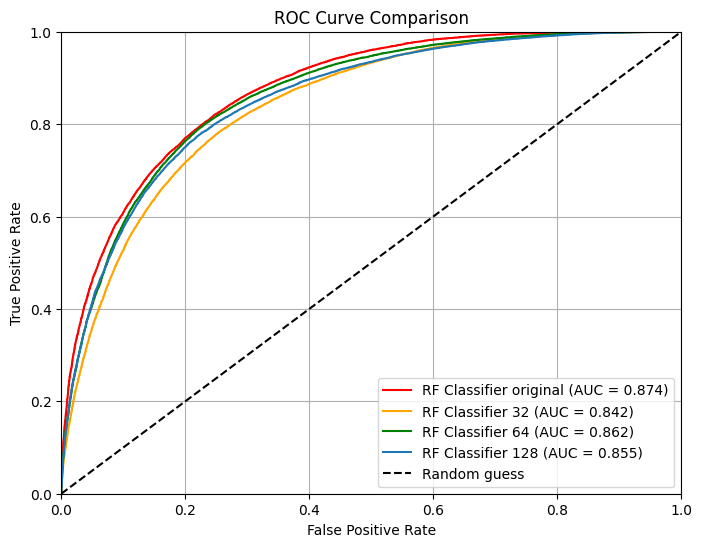

In [4]:
plot_roc_curve_4(results_cl_64_df['event_type'],
                 results_cl_64_df['predicted_proba_original'], 
                 results_cl_32_df['predicted_proba_improved'], 
                 results_cl_64_df['predicted_proba_improved'], 
                 results_cl_128_df['predicted_proba_improved'],
                 label1="RF Classifier original", 
                 label2="RF Classifier 32", 
                 label3="RF Classifier 64",
                 label4="RF Classifier 128")

/home/user/miniforge3/envs/ctlearn/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/user/miniforge3/envs/ctlearn/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


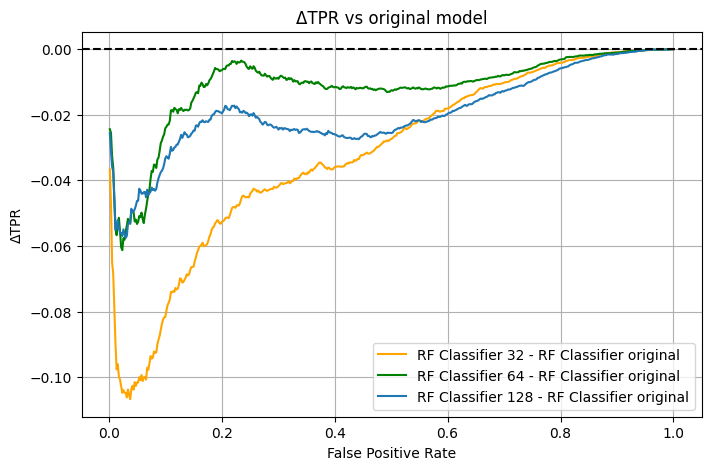

In [5]:
import numpy as np
from scipy.interpolate import interp1d

# Grille FPR commune
fpr_common = np.linspace(0, 1, 500)

fpr1, tpr1, _ = roc_curve(results_cl_64_df['event_type'], results_cl_64_df['predicted_proba_original'])
fpr2, tpr2, _ = roc_curve(results_cl_64_df['event_type'], results_cl_64_df['predicted_proba_improved'])
fpr3, tpr3, _ = roc_curve(results_cl_32_df['event_type'], results_cl_32_df['predicted_proba_improved'])
fpr4, tpr4, _ = roc_curve(results_cl_128_df['event_type'], results_cl_128_df['predicted_proba_improved'])

# Interpolation des TPR
tpr_orig_i = interp1d(fpr1, tpr1, bounds_error=False, fill_value="extrapolate")(fpr_common)
tpr_64_i   = interp1d(fpr2, tpr2, bounds_error=False, fill_value="extrapolate")(fpr_common)
tpr_32_i   = interp1d(fpr3, tpr3, bounds_error=False, fill_value="extrapolate")(fpr_common)
tpr_128_i  = interp1d(fpr4, tpr4, bounds_error=False, fill_value="extrapolate")(fpr_common)

# ΔTPR
delta_64  = tpr_64_i  - tpr_orig_i
delta_32  = tpr_32_i  - tpr_orig_i
delta_128 = tpr_128_i - tpr_orig_i

# Plot
plt.figure(figsize=(8,5))
plt.plot(fpr_common, delta_32, label="RF Classifier 32 - RF Classifier original", color="orange")
plt.plot(fpr_common, delta_64, label="RF Classifier 64 - RF Classifier original", color="green")
plt.plot(fpr_common, delta_128, label="RF Classifier 128 - RF Classifier original")

plt.axhline(0, linestyle="--", color="black")

plt.xlabel("False Positive Rate")
plt.ylabel("ΔTPR")
plt.title("ΔTPR vs original model")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
x_bins, res = resolution_per_bin(results_rg_64_df['true_energy'], results_rg_64_df['true_energy'], results_rg_64_df['predicted_energy_original'], relative_scaling_method='s1', bins=20)
x_bins_improved_64, res_improved_64 = resolution_per_bin(results_rg_64_df['true_energy'], results_rg_64_df['true_energy'], results_rg_64_df['predicted_energy_improved'], relative_scaling_method='s1', bins=20)
x_bins_improved_32, res_improved_32 = resolution_per_bin(results_rg_32_df['true_energy'], results_rg_32_df['true_energy'], results_rg_32_df['predicted_energy_improved'], relative_scaling_method='s1', bins=20)

x_bins_improved_128, res_improved_128 = resolution_per_bin(results_rg_128_df['true_energy'], results_rg_128_df['true_energy'], results_rg_128_df['predicted_energy_improved'], relative_scaling_method='s1', bins=20)

In [7]:
def plot_resolution_4_curves(
    x_bins_1, res1,
    x_bins_2, res2,
    x_bins_3, res3,
    x_bins_4, res4,
    label1="Curve 1",
    label2="Curve 2",
    label3="Curve 3",
    label4="Curve 4",
    xlabel="Energy (TeV)",
    ylabel="Resolution",
    title="Energy Resolution Comparison"
):
    
    x_bins_1 = 10**x_bins_1
    x_bins_2 = 10**x_bins_2
    x_bins_3 = 10**x_bins_3
    x_bins_4 = 10**x_bins_4


    # Centres des bins
    x1 = 0.5 * (x_bins_1[:-1] + x_bins_1[1:])
    x2 = 0.5 * (x_bins_2[:-1] + x_bins_2[1:])
    x3 = 0.5 * (x_bins_3[:-1] + x_bins_3[1:])
    x4 = 0.5 * (x_bins_4[:-1] + x_bins_4[1:])

    y1 = res1[:, 0]
    y2 = res2[:, 0]
    y3 = res3[:, 0]
    y4 = res4[:, 0]

    plt.figure(figsize=(8, 6))

    plt.plot(x1, y1, "--o", label=label1, color="red")
    plt.plot(x2, y2, "--o", label=label2, color="orange")
    plt.plot(x3, y3, "--o", label=label3, color="green")
    plt.plot(x4, y4, "--o", label=label4)

    ax = plt.gca()
    ax.set_xscale("log")

    plt.ylim(0, 1)
    plt.xlim(1, None)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.title(title)

    plt.tight_layout()
    plt.show()


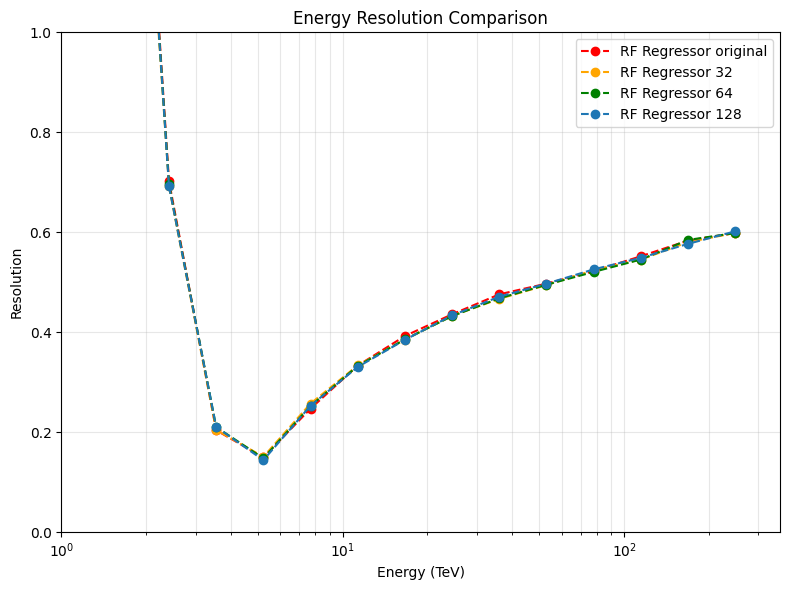

In [8]:
plot_resolution_4_curves(
    x_bins, res,
    x_bins_improved_32, res_improved_32,
    x_bins_improved_64, res_improved_64,
    x_bins_improved_128, res_improved_128,
    label1="RF Regressor original",
    label2="RF Regressor 32",
    label3="RF Regressor 64",
    label4="RF Regressor 128",
    title="Energy Resolution Comparison"
)

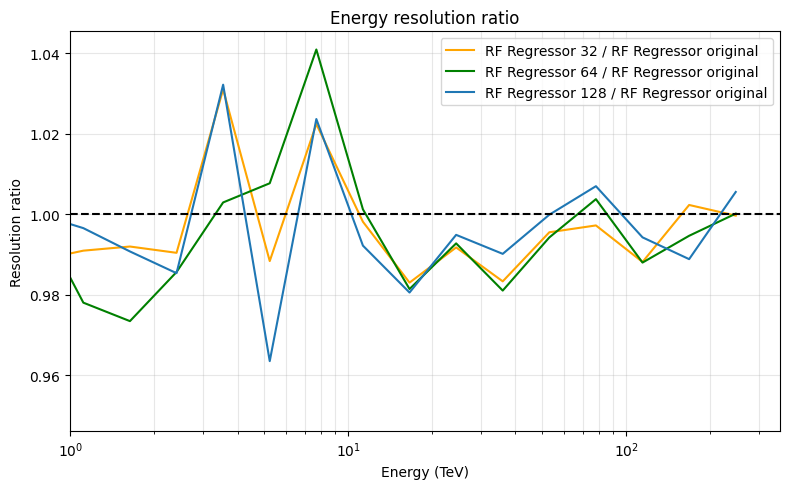

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


def plot_resolution_ratio_vs_original(
    x_bins_ref, res_ref,
    x_bins_32, res_32,
    x_bins_64, res_64,
    x_bins_128, res_128,
    label_ref="Original",
    label_32="RF Regressor 32",
    label_64="RF Regressor 64",
    label_128="RF Regressor 128",
    xlabel="Energy (TeV)",
    ylabel="Resolution ratio",
    title="Resolution ratio vs original"
):
    # --- Convert log-bins to linear scale ---
    x_bins_ref = 10**x_bins_ref
    x_bins_64  = 10**x_bins_64
    x_bins_32  = 10**x_bins_32
    x_bins_128 = 10**x_bins_128

    # --- Bin centers ---
    x_ref = 0.5 * (x_bins_ref[:-1] + x_bins_ref[1:])
    x_64  = 0.5 * (x_bins_64[:-1]  + x_bins_64[1:])
    x_32  = 0.5 * (x_bins_32[:-1]  + x_bins_32[1:])
    x_128 = 0.5 * (x_bins_128[:-1] + x_bins_128[1:])

    y_ref = res_ref[:, 0]
    y_64  = res_64[:, 0]
    y_32  = res_32[:, 0]
    y_128 = res_128[:, 0]

    # --- Cleaning (strictly positive & finite) ---
    def clean_xy(x, y):
        mask = (x > 0) & np.isfinite(x) & np.isfinite(y)
        return x[mask], y[mask]

    x_ref, y_ref = clean_xy(x_ref, y_ref)
    x_64,  y_64  = clean_xy(x_64,  y_64)
    x_32,  y_32  = clean_xy(x_32,  y_32)
    x_128, y_128 = clean_xy(x_128, y_128)

    # --- Common energy grid (log-spaced) ---
    E_min = min(x_ref.min(), x_64.min(), x_32.min(), x_128.min())
    E_max = max(x_ref.max(), x_64.max(), x_32.max(), x_128.max())

    E_common = np.logspace(np.log10(E_min), np.log10(E_max), 20)

    # --- Interpolation ---
    interp_ref = interp1d(x_ref, y_ref, bounds_error=False, fill_value="extrapolate")
    interp_64  = interp1d(x_64,  y_64,  bounds_error=False, fill_value="extrapolate")
    interp_32  = interp1d(x_32,  y_32,  bounds_error=False, fill_value="extrapolate")
    interp_128 = interp1d(x_128, y_128, bounds_error=False, fill_value="extrapolate")

    y_ref_i = interp_ref(E_common)
    y_64_i  = interp_64(E_common)
    y_32_i  = interp_32(E_common)
    y_128_i = interp_128(E_common)

    # --- Ratio ---
    ratio_64  = y_64_i  / y_ref_i
    ratio_32  = y_32_i  / y_ref_i
    ratio_128 = y_128_i / y_ref_i

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    
    plt.plot(E_common, ratio_32,  label=f"{label_32} / {label_ref}", color="orange")
    plt.plot(E_common, ratio_64,  label=f"{label_64} / {label_ref}", color="green")
    plt.plot(E_common, ratio_128, label=f"{label_128} / {label_ref}")

    plt.axhline(1.0, linestyle="--", color="black")
    plt.xscale("log")
    plt.xlim(1, None)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_resolution_ratio_vs_original(
    x_bins, res,
    x_bins_improved_64, res_improved_64,
    x_bins_improved_32, res_improved_32,
    x_bins_improved_128, res_improved_128,
    label_ref="RF Regressor original",
    label_32="RF Regressor 32",
    label_64="RF Regressor 64",
    label_128="RF Regressor 128",
    xlabel="Energy (TeV)",
    ylabel="Resolution ratio",
    title="Energy resolution ratio"
)
